# 개발 목표: 
close_high_low 를 lstm으로 학습 시킨다.
volume 지표를 sigmoid 함수에 넣은 후 lstm output 과 volume -> sigmoid 를 곱한다. 볼륨에 따른 확률 조정을 하는 것이다. 그 후 softmax 를 하고 확률로 변환 시킨다. 정규화 조건은 N(0 1) 로 정규분포 전환.

a.데이터 정규화
   N(0,1) 로 전환후 mean std 데이터를 저장한다.(high low close volume)
   TF 데이터는 0 또는 1로 만들어준다.
b. 데이터 전처리
   seq_len = 30 으로 설정후 high low close volume 을 가공한다.
c. 모델구성
    LSTM 을 high low close 따로 volume 따로 넣어준다.
    volume lstm 의 output 을 sigmoid 함수에 넣어준다.(확률 조정을 의미)
    high low close 의 output 과 volume sigmoid 를 곱해준다
    그러고 나서 logistic 회귀를 실행
    


# std data

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 18.3MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp37-cp37m-linux_x86_64.whl size=1437995 sha256=72b1a7d93971b195c7c002bd3e3959204c7f4600a2158ec61b2e3bfd526141d3
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3d1ccd06caadd8fa47e016991dd0d27f1163bb260f1854e2ff
Successfully built ta-lib


In [ ]:
from google.colab import files
import pandas as pd
import time
import talib
import numpy as np
from google.colab import drive
import csv

filename1 = '/content/drive/MyDrive/DATA/Binance_BTCUSDT_minute.csv'
df = pd.read_csv(filename1)
df = df.sort_values(by=['date'], axis=0)
df = pd.DataFrame.reset_index(df)
df = df.loc[150000:]
df = pd.DataFrame.reset_index(df)
close = np.array(df['close'].values)
open = np.array(df['open'].values)
high = np.array(df['high'].values)
low = np.array(df['low'].values)
volume = np.array(df['Volume BTC'].values)



mdata = []
sdata = []
md = pd.DataFrame()
sd = pd.DataFrame()
class trt :
  def tf(self,value,tp,name):
    input = talib.ROC(value, timeperiod=tp)
    transfrom = np.round(input,2)
    df[name] = transfrom

class tra :
  def tf(self,value,tp,name):
    dat = talib.ROC(value, timeperiod=tp)
    dat1 = dat[tp:]
    std_data = np.round((dat1 - np.mean(dat1,axis = 0))/ np.std(dat1,axis = 0),3)
    fill =np.random.rand(tp)
    fill = np.zeros_like(fill)
    std_data = np.r_[fill,std_data]
    df[name] = std_data
    mean = np.round(np.mean(dat1,axis = 0),3)
    std = np.round(np.std(dat1,axis = 0),3)
    mdata.append(mean)
    sdata.append(std)

    

class trb :
  def tf(self,value,tp,name):
    # dat = (talib.MA(value, timeperiod=tp))*(talib.MA(close, timeperiod=tp))
    dat1 = volume[tp:]
    std_data = np.round((dat1 - np.mean(dat1,axis = 0))/ np.std(dat1,axis = 0),3)
    fill =np.random.rand(tp)
    fill = np.zeros_like(fill)
    std_data = np.r_[fill,std_data]
    df[name] = std_data

    mean = np.round(np.mean(dat1,axis = 0),3)
    std = np.round(np.std(dat1,axis = 0),3)
    mdata.append(mean)
    sdata.append(std)

c1 = tra()
c2 = tra()
c3 = tra()

v1 = trb()

c5 = trt()


c1.tf(close,1,'close_1')
c2.tf(high,1,'high_1')
c3.tf(low,1,'low_1')

v1.tf(volume,1,'volume_1')

c5.tf(close,2,'change_2')




data = pd.DataFrame(df)


md = md.append(pd.Series(mdata), ignore_index=True)
sd = sd.append(pd.Series(sdata), ignore_index=True)

data1 = data.loc[2:156435,:]
TF1 = data.loc[4:156437,'change_2']
data1 = data1.drop(['level_0'],axis=1)
data1 = pd.DataFrame.reset_index(data1)
# print(mdata)
# print(sdata)
# print(data1)
# print(TF1)

print(md)
print(sd)
# data1.to_csv('dataF.csv')
# files.download('dataF.csv')
# TF1.to_csv('TFF.csv')
# files.download('TFF.csv')
# md.to_csv('mdata.csv')
# files.download('mdata.csv')
# sd.to_csv('sdata.csv')
# files.download('sdata.csv')

       0      1      2       3
0  0.001  0.001  0.001  59.361
       0      1      2       3
0  0.287  0.276  0.283  64.115


# Set Train DATA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np

filename2 = '/content/drive/MyDrive/LSTM DATAre/dataF.csv'


data1 = pd.read_csv(filename2)


data = data1.loc[86434:,'close_1':'volume_1']
data = data.to_numpy()
dnumber_idx = 156433

class traindata:
    def start(self, seq_len, data, data_len , c_num ):
      end = data_len - seq_len + 1
      empty = np.zeros((data_len - seq_len + 1, seq_len, c_num))
      for f in range(end):
        for i in range(seq_len):
          val = data[i+f,:]
          empty[f,i,:] = val
      return empty

train = traindata()
td = train.start(seq_len = 30, data = data, data_len = 70000, c_num = 4)
td = np.round(td,3)
train = td[:,:,0:3]
print(train.shape)
volume = td[:,:,-1]
print(volume.shape)
seq_len = 30
data_len =70000

Tlqkf = data1['close'].values
Tlqkf = Tlqkf[86434:]
Tlqkf = Tlqkf[seq_len -1:data_len]

print(Tlqkf[0:10])
print(td[0:10,-1,0])
np.save('/content/drive/MyDrive/LSTM DATAre/train_close',Tlqkf)

np.save('/content/drive/MyDrive/LSTM DATAre/train_lstm', train)
np.save('/content/drive/MyDrive/LSTM DATAre/volume_lstm',volume)


(69971, 30, 3)
(69971, 30)
[47263.43 47262.9  47296.15 47213.63 47200.67 47175.27 47023.72 47368.36
 47340.46 47179.77]
[ 0.448 -0.007  0.241 -0.61  -0.099 -0.191 -1.121  2.546 -0.208 -1.184]


# TF DATA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np


filename1 = '/content/drive/MyDrive/LSTM DATAre/TFF.csv'


TF = pd.read_csv(filename1)

TF = TF.loc[86434:,:]
print(TF)
TF = TF.to_numpy()
data = pd.read_csv(filename1)
dnumber = 156433

class one_hot_ytrain:
  def start(self,data,data_len,seq_len):
    data = data[:,1]
    print(data)
    data = data*100
    data = np.round(data,2)
    empty = np.zeros((data_len - seq_len + 1, 3))
    for i in range(seq_len - 1 ,data_len):
      if data[i] > 10:
        data[i] = 1
        empty[i - seq_len +1,0] = 1
      elif data[i] < -10:
        data[i] = 0
        empty[i - seq_len +1,1]  = 1
      else :
        data[i] = 0
        empty[i - seq_len +1,2] = 1
    data = data[seq_len -1 : data_len]
    print(empty)
    print(empty.shape)
    return data

y_train = one_hot_ytrain()
y_train = y_train.start(data = TF,data_len=70000, seq_len=30)
print(y_train.shape)
print(y_train[0:10])
# y_train = pd.DataFrame(y_train)
# y_train.to_csv('TF_lstmempty.csv')
# files.download('TF_lstmempty.csv')
np.save('/content/drive/MyDrive/LSTM DATAre/TFce1_lstm', y_train)

# for i in range(10):
#   print(y_train[i,:])
# 39 ~ 99번 까지의 답을 구함 
# data 의 결과가 같음  / data_original 필요 / data_len = 실제 길이
#data_len = seq_len +1 = 처리하고 나온 데이터

        Unnamed: 0  change_2
86434        86438      0.13
86435        86439     -0.19
86436        86440      0.10
86437        86441      0.52
86438        86442      0.35
...            ...       ...
156429      156433     -0.01
156430      156434      0.03
156431      156435     -0.07
156432      156436     -0.05
156433      156437      0.12

[70000 rows x 2 columns]
[ 0.13 -0.19  0.1  ... -0.07 -0.05  0.12]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
(69971, 3)
(69971,)
[0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


# Nmodel

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import torch.nn.functional as F
import pandas as pd
import numpy as np
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeors(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
        return final

train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
TF_n = np.load('/content/drive/MyDrive/LSTM DATAre/TFce1_lstm.npy')
traina = torch.FloatTensor(train_n)
train = traina[40000:60000,:,:].to(gpu)
trainv = traina[60000:,:,:].to(gpu)
volumea = torch.FloatTensor(volume_n)
volume = volumea[40000:60000,:].to(gpu)
volumev = volumea[60000:,:].to(gpu)
TFa = torch.LongTensor(TF_n)
TF = TFa[40000:60000].to(gpu)
print(TF.shape)
TFv = TFa[60000:].to(gpu)

model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0.2, vinput_size = 1, vhidden_size = 10).to(gpu)
# test
# a = torch.randn(10,5,3)
# b = torch.randn(10,5)
# target = model(a,b)
# print(target)

optimizer = optim.Adam(model.parameters(), lr=0.01)
best_model_wts = model.state_dict() 
best_acc = 0
best_epoch = 0
l_array = []
a_array = []
criterion = nn.CrossEntropyLoss()
for epoch in range(250):
  for i in range(2):
    if i == 0:
      output = model(train,volume)
      # loss = (torch.abs((output - TF))).mean()
      loss = criterion(output, TF)
      
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass
    
    if i == 1:
      pred = model(trainv,volumev)
      accuracy = criterion(pred,TFv)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if best_acc > accuracy:
        best_model_wts = model.state_dict()
        best_acc = accuracy
        best_ephoch = epoch
      if (epoch+1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy))
    else:
      pass

plt.plot(l_array, 'r')
plt.plot(a_array,'b')
plt.show()
model_save_name = 'MODEL_simpn.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

cuda
torch.Size([20000])


AttributeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import torch.nn.functional as F
import pandas as pd
import numpy as np
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeros(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
          
        return final

train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
TF_n = np.load('/content/drive/MyDrive/LSTM DATAre/TFce1_lstm.npy')
traina = torch.FloatTensor(train_n)
train = traina[40000:60000,:,:].to(gpu)
trainv = traina[60000:,:,:].to(gpu)
volumea = torch.FloatTensor(volume_n)
volume = volumea[40000:60000,:].to(gpu)
volumev = volumea[60000:,:].to(gpu)
TFa = torch.LongTensor(TF_n)
TF = TFa[40000:60000].to(gpu)
print(TF.shape)
TFv = TFa[60000:].to(gpu)

model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0.2, vinput_size = 1, vhidden_size = 10).to(gpu)
# test
# a = torch.randn(10,5,3)
# b = torch.randn(10,5)
# target = model(a,b)
# print(target)

optimizer = optim.Adam(model.parameters(), lr=0.01)
best_model_wts = model.state_dict() 
best_acc = 0
best_epoch = 0
l_array = []
a_array = []
criterion = nn.CrossEntropyLoss()
for epoch in range(300):
  for i in range(2):
    if i == 0:
      output = model(train,volume)
      # loss = (torch.abs((output - TF))).mean()
      loss = criterion(output, TF)
      
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass
    
    if i == 1:
      pred = model(trainv,volumev)
      accuracy = criterion(pred,TFv)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if best_acc > accuracy:
        best_model_wts = model.state_dict()
        best_acc = accuracy
        best_ephoch = epoch
      if (epoch+1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy))
    else:
      pass

plt.plot(l_array, 'r')
plt.plot(a_array,'b')
plt.show()
model_save_name = 'MODEL_simp.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

cuda
torch.Size([20000])


# Valid

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)
class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        output = torch.unsqueeze(output,dim = 0)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        outputv = torch.unsqueeze(outputv,dim= 0)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeros(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
        final = F.softmax(final)
          
        return final
train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
train = torch.FloatTensor(train_n).to(gpu)

volume = torch.FloatTensor(volume_n).to(gpu)
# print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/MODEL_simp.pt'
model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
model.load_state_dict(torch.load(model_wts))
modeln_wts = '/content/drive/MyDrive/MODEL_simps.pt'
modeln = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
modeln.load_state_dict(torch.load(modeln_wts))
# print(train1.shape)
target = model(train[63000,:,:],volume[63000,:])
# if i in range(30000,30010):
#   target = model(train[i,:,:],volume[i,:])
#   print(target)
print(target)
print(target[-1,-1])
print(target[-1,-2])
l = []
all = []
anjwl = []
for i in range(60000,65000):
  target1 = model(train[i,:,:], volume[i,:])
  target = target1[-1,-1]
  a = target1[-1,-2]
  all.append(target.item())
  limit = modeln(train[i,:,:],volume[i,:])
  limitn = limit[-1,-1]
  if  target > 0.85 and limitn < 0.3:
    l.append(target.item())
    anjwl.append(train[i+2,-1,0]+train[i+1,-1,0])

print(len(l))
print(l)
print(sum(all)/len(all))
print(anjwl)
print(sum(anjwl)/len(anjwl))
print(len(anjwl))


cuda
tensor([[0.9516, 0.0484]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(0.0484, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.9516, device='cuda:0', grad_fn=<SelectBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


6
[0.8681678771972656, 0.9293018579483032, 0.8673405051231384, 0.8589992523193359, 0.8662785291671753, 0.8633450865745544]
0.13296541666686534
[tensor(-1.0420, device='cuda:0'), tensor(0.9230, device='cuda:0'), tensor(0.4640, device='cuda:0'), tensor(0.9940, device='cuda:0'), tensor(0.0080, device='cuda:0'), tensor(0.6440, device='cuda:0')]
tensor(0.3318, device='cuda:0')
6


# New BT

cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[56100.01, 56041.36, 57993.15, 56000.0, 58205.62, 60916.68]
6
[56142.88, 56117.14, 58098.57, 56130.47, 58189.51, 60980.0]
6
125.54454399999997


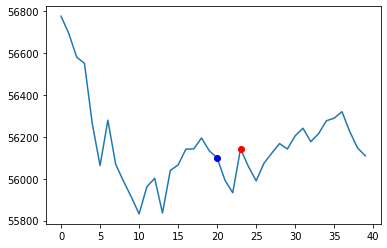

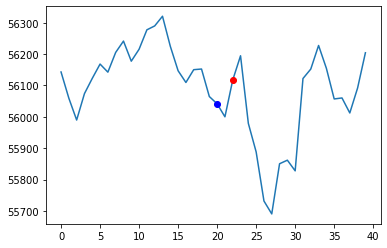

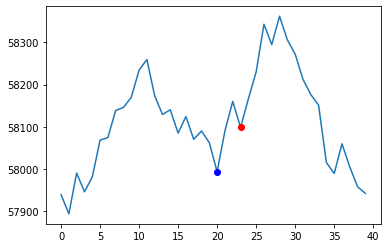

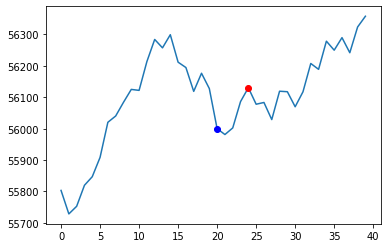

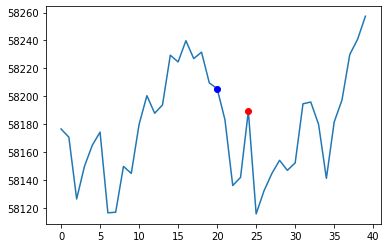

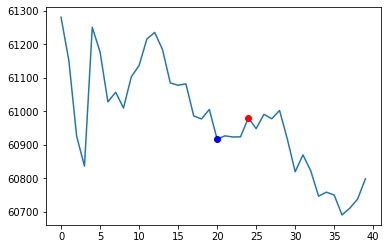

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)


class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        output = torch.unsqueeze(output,dim = 0)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        outputv = torch.unsqueeze(outputv,dim= 0)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeros(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
        final = F.softmax(final)
          
        return final

train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
train = torch.FloatTensor(train_n).to(gpu)
volume = torch.FloatTensor(volume_n).to(gpu)
close = np.load('/content/drive/MyDrive/LSTM DATAre/train_close.npy')
# print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/MODEL_simp.pt'
model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
model.load_state_dict(torch.load(model_wts))

modeln_wts = '/content/drive/MyDrive/MODEL_simps.pt'
modeln = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
modeln.load_state_dict(torch.load(modeln_wts))


buy = []
sell = []
start = 60000
end = 67000
lin = 0.85
l = 0 
lopen = 0
high = 0
lbx = []

sindex = 0

buydata = []

bindex = []
buyprice = []

sellindex = []
sellprice = []

for i in range(start, end):
  target = model(train[i,:,:],volume[i])
  target = target[-1,-1]
  price = close[i]
  sellp = close[i+2]
  data = close[i-20:i+20].tolist()
  limit = modeln(train[i,:,:],volume[i])
  limitn = limit[-1,-1]
  if target > lin and l == 0 and limitn < 0.3:
    buy.append(price)

    sindex = i
    buydata.append(data)
    bindex.append([20])
    buyprice.append([price])
    # high = price

    l += 1
  if l == 1:
    # if ((price - high)*100/high) < -0.05:
    if target < 0.6:
      sell.append(price)

      si = i - sindex
      sellindex.append([20+si])
      sellprice.append([price])
      l += -1
  if l == 1 :
    if high < price:
      high = price
print(buy)
print(len(buy))
print(sell)
print(len(sell))
print(sum(sell)-sum(buy)-sum(buy)*0.0008)
# print(buydata[0])
# plt.plot(buydata[0])
# plt.plot(bindex[0],buyprice[0],'bo')
# plt.show()
# print(bindex[0])
# print(buyprice[0])
for i in range(len(buy)):
  plt.plot(buydata[i])
  plt.plot(bindex[i],buyprice[i],'bo')
  plt.plot(sellindex[i],sellprice[i],'ro')
  plt.show()

# 검증 섹션

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np

a = torch.FloatTensor([[0,1],[1,0]])
b = torch.LongTensor([1,0])
# weight = torch.FloatTensor([1,0.7])
# criterion = nn.CrossEntropyLoss(weight = weight)
criterion = nn.CrossEntropyLoss()
loss = criterion(a,b)
print(loss)

tensor(0.8133)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np

a = np.load('/content/drive/MyDrive/LSTM DATAre/TF_lstm.npy')
print(a[0:30])
b = np.load('/content/drive/MyDrive/LSTM DATAre/TFce_lstm.npy')
print(b[0:30])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
output = [0.8982, 0.805, 0.6393, 0.9983, 0.5731, 0.0469, 0.556, 0.1476, 0.8404, 0.5544]
target = [1]
loss = np.log(sum(np.exp(output))) - output[target[0]]
print(loss) # 2.143818427948945
print(output[target[0]])
print(np.log(sum(np.exp(output))))

2.143818427948945
0.805
2.9488184279489453


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np

a = pd.read_csv('/content/drive/MyDrive/LSTM DATAre/sdata.csv')
print(a)

   Unnamed: 0      0      1      2       3
0           0  0.287  0.276  0.283  64.115


# S TF DATA

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np


filename1 = '/content/drive/MyDrive/LSTM DATAre/TFF.csv'


TF = pd.read_csv(filename1)

TF = TF.loc[86434:,:]
print(TF)
TF = TF.to_numpy()
data = pd.read_csv(filename1)
dnumber = 156433

class one_hot_ytrain:
  def start(self,data,data_len,seq_len):
    data = data[:,1]
    print(data[data_len-10:data_len])
    print(data[70000-10:data_len])
    data = data*100
    data = np.round(data,1)
    empty = np.zeros((data_len - seq_len + 1, 3))
    for i in range(seq_len - 1 ,data_len):
      if data[i] > 10:
        data[i] = 0
        empty[i - seq_len +1,0] = 1
      elif data[i] < -10:
        data[i] = 1
        empty[i - seq_len +1,1]  = 1
      else :
        data[i] = 0
        empty[i - seq_len +1,2] = 1
    data = data[seq_len -1 : data_len]
    return data

y_train = one_hot_ytrain()
y_train = y_train.start(data = TF,data_len=70000, seq_len=30)
print(y_train.shape)
print(y_train[-10:])
# y_train = pd.DataFrame(y_train)
# y_train.to_csv('TF_lstmempty.csv')
# files.download('TF_lstmempty.csv')
np.save('/content/drive/MyDrive/LSTM DATAre/TFce1s_lstm', y_train)

# for i in range(10):
#   print(y_train[i,:])
# 39 ~ 99번 까지의 답을 구함 
# data 의 결과가 같음  / data_original 필요 / data_len = 실제 길이
#data_len = seq_len +1 = 처리하고 나온 데이터

# S Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import torch.nn.functional as F
import pandas as pd
import numpy as np
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)

class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeros(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
        return final

train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
TF_n = np.load('/content/drive/MyDrive/LSTM DATAre/TFce1s_lstm.npy')
traina = torch.FloatTensor(train_n)
train = traina[40000:60000,:,:].to(gpu)
trainv = traina[60000:,:,:].to(gpu)
volumea = torch.FloatTensor(volume_n)
volume = volumea[40000:60000,:].to(gpu)
volumev = volumea[60000:,:].to(gpu)
TFa = torch.LongTensor(TF_n)
TF = TFa[40000:60000].to(gpu)
print(TF.shape)
TFv = TFa[60000:].to(gpu)

model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0.2, vinput_size = 1, vhidden_size = 10).to(gpu)
# test
# a = torch.randn(10,5,3)
# b = torch.randn(10,5)
# target = model(a,b)
# print(target)

optimizer = optim.Adam(model.parameters(), lr=0.01)
best_model_wts = model.state_dict() 
best_acc = 0
best_epoch = 0
l_array = []
a_array = []
criterion = nn.CrossEntropyLoss()
for epoch in range(250):
  for i in range(2):
    if i == 0:
      output = model(train,volume)
      # loss = (torch.abs((output - TF))).mean()
      loss = criterion(output, TF)
      
      loss1 = loss.tolist()
      l_array.append(loss1)

      if (epoch + 1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    else:
      pass
    
    if i == 1:
      pred = model(trainv,volumev)
      accuracy = criterion(pred,TFv)
      ac1 = accuracy.tolist()
      a_array.append(ac1)
      if best_acc > accuracy:
        best_model_wts = model.state_dict()
        best_acc = accuracy
        best_ephoch = epoch
      if (epoch+1) % 10 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'accuracy =', '{:.6f}'.format(accuracy))
    else:
      pass

plt.plot(l_array, 'r')
plt.plot(a_array,'b')
plt.show()
model_save_name = 'MODEL_simps.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# S VALID

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)
class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        output = torch.unsqueeze(output,dim = 0)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        outputv = torch.unsqueeze(outputv,dim= 0)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeros(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
        final = F.softmax(final)
          
        return final
train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
train = torch.FloatTensor(train_n).to(gpu)

volume = torch.FloatTensor(volume_n).to(gpu)
# print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/MODEL_simps.pt'
model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
model.load_state_dict(torch.load(model_wts))
modeln_wts = '/content/drive/MyDrive/MODEL_simp.pt'
modeln = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
modeln.load_state_dict(torch.load(modeln_wts))
# print(train1.shape)
target = model(train[63111,:,:],volume[63111,:])
# if i in range(30000,30010):
#   target = model(train[i,:,:],volume[i,:])
#   print(target)
print(target)
print(target[-1,-1])
print(target[-1,-2])
l = []
all = []
anjwl = []
targetlong = []
targetlongf = []
for i in range(60000,67000):
  target1 = model(train[i,:,], volume[i,:])
  target = target1[-1,-1]
  targetn = modeln(train[i,:,],volume[i,:])
  targetnn = targetn[-1,-1]
  a = target1[-1,-2]
  all.append(target.item())
  if  target > 0.6:
    l.append(target.item())
    anjwl.append(train[i+2,-1,0]+train[i+1,-1,0])
    if (train[i+2,-1,0]+train[i+1,-1,0]) > 0:
      targetlong.append(targetnn.item())
    else:
      targetlongf.append(targetnn.item())

print(len(l))
print(l)
print(sum(targetlong)/len(targetlong))
print(sum(targetlongf)/len(targetlongf))
print(sum(all)/len(all))
print(anjwl)
print(sum(anjwl)/len(anjwl))
print(len(anjwl))


cuda
tensor([[0.9318, 0.0682]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(0.0682, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.9318, device='cuda:0', grad_fn=<SelectBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


32
[0.6293310523033142, 0.6170874834060669, 0.6219369769096375, 0.601577639579773, 0.6074752807617188, 0.6132169365882874, 0.6076318621635437, 0.7203049659729004, 0.6430484652519226, 0.6719740033149719, 0.6168610453605652, 0.6142028570175171, 0.6007257699966431, 0.6024709343910217, 0.6209794878959656, 0.6390165686607361, 0.6004357933998108, 0.6360082626342773, 0.6252166032791138, 0.6794918775558472, 0.6305663585662842, 0.6238123178482056, 0.6351383328437805, 0.6276472806930542, 0.6052846312522888, 0.6045017838478088, 0.6506413221359253, 0.7108632326126099, 0.6830792427062988, 0.6173631548881531, 0.6066264510154724, 0.6802919507026672]
0.2210917780175805
0.3038827683776617
0.13669074484360005
[tensor(-0.3580, device='cuda:0'), tensor(-0.6050, device='cuda:0'), tensor(-0.1340, device='cuda:0'), tensor(0.6020, device='cuda:0'), tensor(0.4260, device='cuda:0'), tensor(0.0090, device='cuda:0'), tensor(0.4680, device='cuda:0'), tensor(-0.5950, device='cuda:0'), tensor(-0.9560, device='cuda:0

# S BackTest

# 새 섹션

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from google.colab import auth
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import torch.nn.functional as F
gpu = 'cuda' if torch.cuda.is_available() else 'cpu'
print(gpu)
# for reproducibility
torch.manual_seed(777)
if gpu == 'cuda':
    torch.cuda.manual_seed_all(777)


class MultiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, dropout, vinput_size, vhidden_size, bidirectional=False):
        super(MultiLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.vinput_size = vinput_size
        self.vhidden_size = vhidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = 3, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.rnnv = nn.LSTM(vinput_size,vhidden_size, num_layers = 2, dropout = dropout, batch_first = True , bidirectional = bidirectional)
        self.fc = nn.Linear(hidden_size,2)
        self.fcv = nn.Linear(vhidden_size,2)

    def forward(self, input, inputv):
        # input shape: batch, seq, dim
        output = input
        output = torch.unsqueeze(output,dim = 0)
        rnn_output, _ = self.rnn(output)
        rnn_output = rnn_output[:,-1,:]
        fc = self.fc(rnn_output)
        sigmoid = torch.sigmoid(fc)
        
        outputv = inputv
        outputv = torch.unsqueeze(outputv,dim= -1)
        outputv = torch.unsqueeze(outputv,dim= 0)
        rnnv_output, _ = self.rnnv(outputv)
        rnnv_output = rnnv_output[:,-1,:]
        fcv = self.fcv(rnnv_output)
        tanhv = torch.tanh(fcv)

        forget = sigmoid.mul(tanhv)
        final = sigmoid + forget
        weight = torch.zeros(final.shape[0],final.shape[1]).to(gpu)
        for j in range(final.shape[0]):
          a = final[j,-1]
          b = final[j,-2]
          weight[j,-1] = a*5/(a+b)
          weight[j,-2] = b*5/(a+b)
        final = final.mul(weight)
        final = F.softmax(final)
          
        return final

train_n = np.load('/content/drive/MyDrive/LSTM DATAre/train_lstm.npy')
volume_n = np.load('/content/drive/MyDrive/LSTM DATAre/volume_lstm.npy')
train = torch.FloatTensor(train_n).to(gpu)
volume = torch.FloatTensor(volume_n).to(gpu)
close = np.load('/content/drive/MyDrive/LSTM DATAre/train_close.npy')
# print(train_lstm.shape)
model_wts = '/content/drive/MyDrive/MODEL_simps.pt'
model = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
model.load_state_dict(torch.load(model_wts))

modeln_wts = '/content/drive/MyDrive/MODEL_simp.pt'
modeln = MultiLSTM(input_size = 3 , hidden_size = 30, dropout = 0, vinput_size = 1, vhidden_size = 10).to(gpu)
modeln.load_state_dict(torch.load(modeln_wts))


buy = []
sell = []
start = 60000
end = 67000
lin = 0.65
l = 0 
lopen = 0
high = 0
lbx = []

sindex = 0

buydata = []

bindex = []
buyprice = []

sellindex = []
sellprice = []

for i in range(start, end):
  target = model(train[i,:,:],volume[i])
  target = target[-1,-1]
  price = close[i]
  sellp = close[i+2]
  data = close[i-20:i+20].tolist()
  limit = modeln(train[i,:,:],volume[i])
  limitn = limit[-1,-1]
  if target > lin and l == 0 and limitn < 0.3:
    buy.append(price)

    sindex = i
    buydata.append(data)
    bindex.append([20])
    buyprice.append([price])
    low = price

    l += 1
  if l == 1:
    # if ((price -low)*100/low) > 0.03:
    if target < 0.4:
      sell.append(price)

      si = i - sindex
      sellindex.append([20+si])
      sellprice.append([price])
      l += -1
  if l == 1 :
    if low > price:
       low = price
print(buy)
print(len(buy))
print(sell)
print(len(sell))
print(sum(buy)-sum(sell)-sum(buy)*0.0008)
# print(buydata[0])
# plt.plot(buydata[0])
# plt.plot(bindex[0],buyprice[0],'bo')
# plt.show()
# print(bindex[0])
# print(buyprice[0])
for i in range(len(buy)):
  plt.plot(buydata[i])
  plt.plot(bindex[i],buyprice[i],'bo')
  plt.plot(sellindex[i],sellprice[i],'ro')
  plt.show()

# CNN TEST

In [ ]:
import torch
import torch.nn as nn
# 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
inputs = torch.randn(1,1,30,3)

conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)
pool = nn.MaxPool2d(1)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
